In [1]:
import os
import sys

import numpy as np
import itertools

from tqdm import tqdm
import re

In [2]:
data_dir = '/hpc/compgen/projects/nanoxog/babe/analysis/mpages/genome_kmer_counts'

In [3]:
kmer_size = 9
pattern = 'k' + str(kmer_size)

In [4]:
matching_files = list()
for f in os.listdir(data_dir):
    if re.search(pattern, f):
        matching_files.append(f)

In [30]:
counts_list = list()
names_list = list()
for f in matching_files:
    counts = np.zeros((4**kmer_size, ), dtype = np.float64)
    with open(os.path.join(data_dir, f), 'r') as of:
        for i, line in enumerate(of):
            counts[i] = int(line.split('\t')[1].strip('\n'))
            
    counts /= np.sum(counts)
    counts_list.append(counts)
    names_list.append(" ".join(f.split('_')[:-1]))
X = np.vstack(counts_list)

In [31]:
names_list = np.array(names_list)
p = np.where((names_list != 'Homo sapiens') & (names_list != 'Lambda phage'))[0] 
names_list = names_list[p]

In [33]:
X = X[p,:]

In [34]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import single, leaves_list, dendrogram
from matplotlib import pyplot as plt

In [35]:
dist = pdist(X, 'jensenshannon')

In [36]:
Z = single(dist)
order = leaves_list(Z)

In [37]:
order = leaves_list(Z)

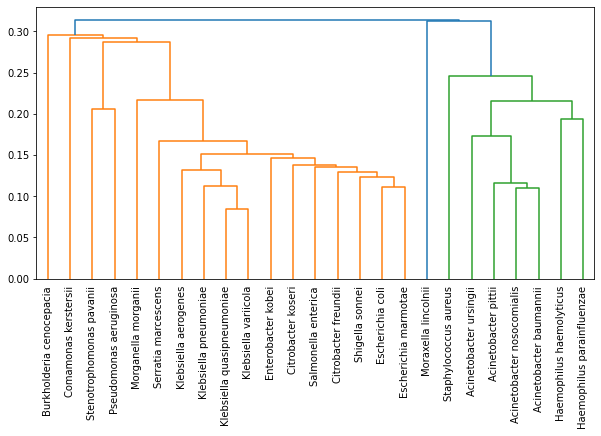

In [38]:
fig = plt.figure(figsize=(10, 5))
dendrogram(Z, labels = names_list, leaf_rotation = 90, color_threshold = 0.3)
plt.show()
fig.savefig('', dpi=fig.dpi, bbox_inches='tight')

In [142]:
with open('/hpc/compgen/projects/nanoxog/babe/analysis/mpages/split_files/clustering_species_order.txt', 'w') as f:
    for s in np.array(names_list)[order].tolist():
        f.write(s + '\n')

In [39]:
dist_matrix = squareform(dist)
dist_matrix = dist_matrix[order, ]
dist_matrix = dist_matrix[:, order]

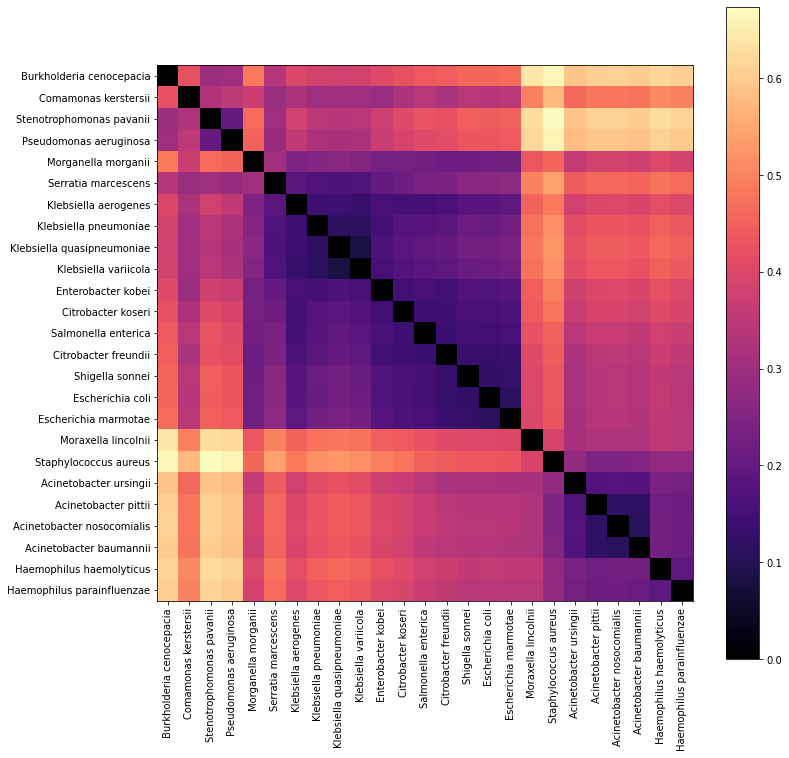

In [40]:
plt.figure(figsize = (12, 12))
plt.imshow(dist_matrix, cmap = plt.get_cmap('magma'))
plt.xticks(np.arange(0, len(names_list), 1), labels = np.array(names_list)[order], rotation = 90)
plt.yticks(np.arange(0, len(names_list), 1), labels = np.array(names_list)[order])
plt.colorbar()
plt.show()

In [146]:
np.savetxt('/hpc/compgen/projects/nanoxog/babe/analysis/mpages/split_files/dist_matrix.txt', dist_matrix)

In [147]:
dist_matrix = np.loadtxt('/hpc/compgen/projects/nanoxog/babe/analysis/mpages/split_files/dist_matrix.txt')

In [43]:
divisions = 4
s = 0
d = np.max(dist_matrix) / divisions
n = np.max(dist_matrix) / divisions
bin_matrix = np.zeros(dist_matrix.shape)
for i in range(divisions+1):
    bin_matrix[ (dist_matrix > s) & (dist_matrix <= n) ] = i
    s = n
    n += d

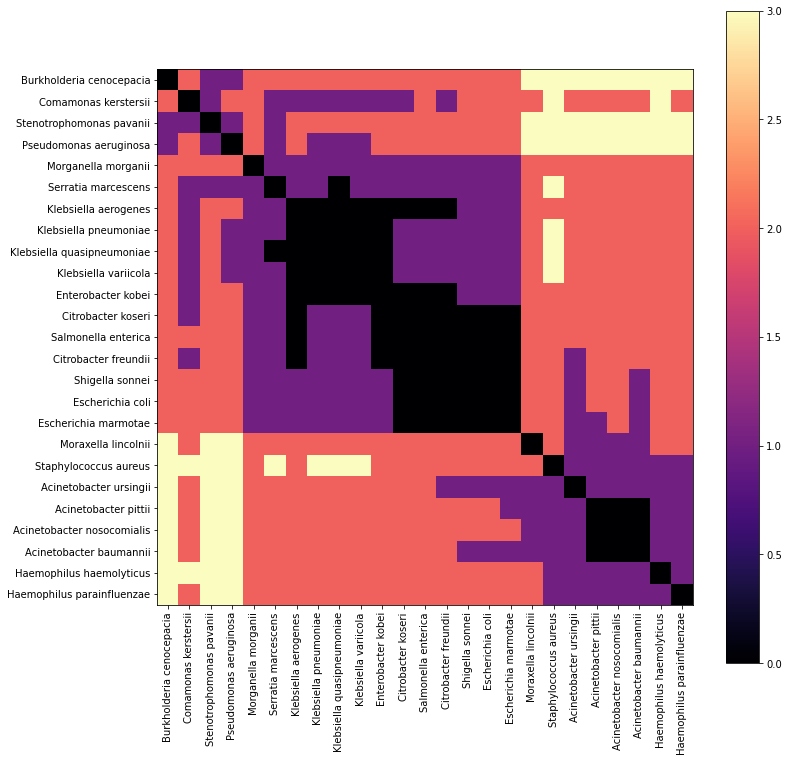

In [44]:
plt.figure(figsize = (12, 12))
plt.imshow(bin_matrix, cmap = plt.get_cmap('magma'))
plt.xticks(np.arange(0, len(names_list), 1), labels = np.array(names_list)[order], rotation = 90)
plt.yticks(np.arange(0, len(names_list), 1), labels = np.array(names_list)[order])
plt.colorbar()
plt.show()

In [150]:
np.savetxt('/hpc/compgen/projects/nanoxog/babe/analysis/mpages/split_files/dist_binarized_matrix.txt', bin_matrix)